In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.risk.final_model_loss_train_risk import *
from model.final_model.risk.final_model_risk import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.risk.plot import *



import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

## load the inbalanced dataset sampler
labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]


train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)


# build the dataloader
train_loader = DataLoader( dataset_train,batch_size=128,sampler=train_sampler,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=128,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=128,shuffle=False,collate_fn=collate_fn)

train_loader_p = DataLoader(dataset_train, batch_size=128, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [4]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30_datasampler/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [5]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_datasampler"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=50, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  theta=1, 
            patience = 5 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint E1] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E1] Calc Global P:   6%|▌         | 1/17 [00:05<01:22,  5.16s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E1] Calc Global P:  18%|█▊        | 3/17 [00:13<00:59,  4.24s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E1] Calc Global P:  24%|██▎       | 4/17 [00:17<00:54,  4.18s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E1] Calc Global P:  29%|██▉       | 5/17 [00:21<00:51,  4.30s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E1] Calc Global P:  35%|███▌      | 6/17 [00:25<00:44,  4.01s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E1] Calc Global P:  41%|████      | 7/17 [00:28<00:37,  3.79s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E1] Calc Global P:  47%|████▋     | 8/17 [00:33<00:36,  4.06s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E1] Calc Global P:  53%|█████▎    | 9/17 [00:37<00:33,  4.25s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E1] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:31,  4.54s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E1] Calc Global P:  65%|██████▍   | 11/17 [00:48<00:27,  4.65s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E1] Calc Global P:  71%|███████   | 12/17 [00:52<00:22,  4.57s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E1] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:17,  4.36s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E1] Calc Global P:  82%|████████▏ | 14/17 [01:01<00:13,  4.59s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E1] Calc Global P:  88%|████████▊ | 15/17 [01:06<00:09,  4.60s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E1] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.33s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1776])
99 --- torch.Size([2, 1776])
711 torch.Size([2, 1776])
EDGE_INDEX: torch.Size([2, 1776])		LOOP_INDEX: torch.Size([2, 711])
241 --- torch.Size([2, 1776])
99 --- torch.Size([2, 1776])
711 torch.Size([2, 1776])
EDGE_INDEX: torch.Size([2, 1776])		LOOP_INDEX: torch.Size([2, 711])
241 --- torch.Size([2, 1542])
99 --- torch.Size([2, 1542])
658 torch.Size([2, 1542])
EDGE_INDEX: torch.Size([2, 1542])		LOOP_INDEX: torch.Size([2, 658])
241 --- torch.Size([2, 1542])
99 --- torch.Size([2, 1542])
658 torch.Size([2, 1542])
EDGE_INDEX: torch.Size([2, 1542])		LOOP_INDEX: torch.Size([2, 658])
241 --- torch.Size([2, 1648])
99 --- torch.Size([2, 1648])
654 torch.Size([2, 1648])
EDGE_INDEX: torch.Size([2, 1648])		LOOP_INDEX: torch.Size([2, 654])
241 --- torch.Size([2, 1648])
99 --- torch.Size([2, 1648])
654 torch.Size([2, 1648])
EDGE_INDEX: torch.Size([2, 1648])		LOOP_INDEX: torch.Size([2, 654])
241 --- torch.Size([2, 1334])
99 --- torch.Size([2, 1334])
582 torch.Size([2, 1334

[Joint E2] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E2] Calc Global P:   6%|▌         | 1/17 [00:04<01:15,  4.69s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E2] Calc Global P:  12%|█▏        | 2/17 [00:08<01:06,  4.43s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E2] Calc Global P:  18%|█▊        | 3/17 [00:13<01:02,  4.48s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E2] Calc Global P:  24%|██▎       | 4/17 [00:17<00:54,  4.19s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E2] Calc Global P:  29%|██▉       | 5/17 [00:21<00:50,  4.18s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E2] Calc Global P:  35%|███▌      | 6/17 [00:24<00:43,  3.91s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E2] Calc Global P:  41%|████      | 7/17 [00:29<00:41,  4.14s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E2] Calc Global P:  47%|████▋     | 8/17 [00:33<00:38,  4.25s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E2] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:34,  4.37s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E2] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:31,  4.44s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E2] Calc Global P:  65%|██████▍   | 11/17 [00:47<00:27,  4.52s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E2] Calc Global P:  71%|███████   | 12/17 [00:52<00:22,  4.52s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E2] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:17,  4.42s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E2] Calc Global P:  82%|████████▏ | 14/17 [01:01<00:13,  4.58s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E2] Calc Global P:  88%|████████▊ | 15/17 [01:05<00:09,  4.55s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E2] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.24s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1682])
99 --- torch.Size([2, 1682])
654 torch.Size([2, 1682])
EDGE_INDEX: torch.Size([2, 1682])		LOOP_INDEX: torch.Size([2, 654])
241 --- torch.Size([2, 1682])
99 --- torch.Size([2, 1682])
654 torch.Size([2, 1682])
EDGE_INDEX: torch.Size([2, 1682])		LOOP_INDEX: torch.Size([2, 654])
241 --- torch.Size([2, 1500])
99 --- torch.Size([2, 1500])
633 torch.Size([2, 1500])
EDGE_INDEX: torch.Size([2, 1500])		LOOP_INDEX: torch.Size([2, 633])
241 --- torch.Size([2, 1500])
99 --- torch.Size([2, 1500])
633 torch.Size([2, 1500])
EDGE_INDEX: torch.Size([2, 1500])		LOOP_INDEX: torch.Size([2, 633])
241 --- torch.Size([2, 1964])
99 --- torch.Size([2, 1964])
709 torch.Size([2, 1964])
EDGE_INDEX: torch.Size([2, 1964])		LOOP_INDEX: torch.Size([2, 709])
241 --- torch.Size([2, 1964])
99 --- torch.Size([2, 1964])
709 torch.Size([2, 1964])
EDGE_INDEX: torch.Size([2, 1964])		LOOP_INDEX: torch.Size([2, 709])
241 --- torch.Size([2, 1810])
99 --- torch.Size([2, 1810])
710 torch.Size([2, 1810

[Joint E3] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E3] Calc Global P:   6%|▌         | 1/17 [00:04<01:12,  4.52s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E3] Calc Global P:  12%|█▏        | 2/17 [00:09<01:09,  4.63s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E3] Calc Global P:  18%|█▊        | 3/17 [00:13<01:04,  4.62s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E3] Calc Global P:  24%|██▎       | 4/17 [00:17<00:56,  4.38s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E3] Calc Global P:  29%|██▉       | 5/17 [00:22<00:52,  4.39s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E3] Calc Global P:  35%|███▌      | 6/17 [00:25<00:45,  4.10s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E3] Calc Global P:  41%|████      | 7/17 [00:30<00:42,  4.23s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E3] Calc Global P:  47%|████▋     | 8/17 [00:34<00:38,  4.29s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E3] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:34,  4.27s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E3] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:31,  4.49s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E3] Calc Global P:  65%|██████▍   | 11/17 [00:48<00:27,  4.57s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E3] Calc Global P:  71%|███████   | 12/17 [00:52<00:22,  4.41s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E3] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:16,  4.20s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E3] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:12,  4.24s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E3] Calc Global P:  88%|████████▊ | 15/17 [01:04<00:08,  4.17s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E3] Calc Global P:  94%|█████████▍| 16/17 [01:08<00:03,  3.94s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1842])
99 --- torch.Size([2, 1842])
722 torch.Size([2, 1842])
EDGE_INDEX: torch.Size([2, 1842])		LOOP_INDEX: torch.Size([2, 722])
241 --- torch.Size([2, 1842])
99 --- torch.Size([2, 1842])
722 torch.Size([2, 1842])
EDGE_INDEX: torch.Size([2, 1842])		LOOP_INDEX: torch.Size([2, 722])
241 --- torch.Size([2, 1590])
99 --- torch.Size([2, 1590])
641 torch.Size([2, 1590])
EDGE_INDEX: torch.Size([2, 1590])		LOOP_INDEX: torch.Size([2, 641])
241 --- torch.Size([2, 1590])
99 --- torch.Size([2, 1590])
641 torch.Size([2, 1590])
EDGE_INDEX: torch.Size([2, 1590])		LOOP_INDEX: torch.Size([2, 641])
241 --- torch.Size([2, 1676])
99 --- torch.Size([2, 1676])
665 torch.Size([2, 1676])
EDGE_INDEX: torch.Size([2, 1676])		LOOP_INDEX: torch.Size([2, 665])
241 --- torch.Size([2, 1676])
99 --- torch.Size([2, 1676])
665 torch.Size([2, 1676])
EDGE_INDEX: torch.Size([2, 1676])		LOOP_INDEX: torch.Size([2, 665])
241 --- torch.Size([2, 1712])
99 --- torch.Size([2, 1712])
696 torch.Size([2, 1712

[Joint E4] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E4] Calc Global P:   6%|▌         | 1/17 [00:04<01:15,  4.69s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E4] Calc Global P:  12%|█▏        | 2/17 [00:09<01:07,  4.48s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E4] Calc Global P:  18%|█▊        | 3/17 [00:13<01:00,  4.31s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E4] Calc Global P:  24%|██▎       | 4/17 [00:16<00:53,  4.11s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E4] Calc Global P:  29%|██▉       | 5/17 [00:21<00:49,  4.15s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E4] Calc Global P:  35%|███▌      | 6/17 [00:24<00:41,  3.76s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E4] Calc Global P:  41%|████      | 7/17 [00:28<00:40,  4.04s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E4] Calc Global P:  47%|████▋     | 8/17 [00:33<00:37,  4.18s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E4] Calc Global P:  53%|█████▎    | 9/17 [00:37<00:33,  4.19s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E4] Calc Global P:  59%|█████▉    | 10/17 [00:42<00:30,  4.33s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E4] Calc Global P:  65%|██████▍   | 11/17 [00:46<00:26,  4.39s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E4] Calc Global P:  71%|███████   | 12/17 [00:50<00:21,  4.21s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E4] Calc Global P:  76%|███████▋  | 13/17 [00:53<00:16,  4.01s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E4] Calc Global P:  82%|████████▏ | 14/17 [00:58<00:12,  4.15s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E4] Calc Global P:  88%|████████▊ | 15/17 [01:02<00:08,  4.12s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E4] Calc Global P:  94%|█████████▍| 16/17 [01:06<00:03,  3.96s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1534])
99 --- torch.Size([2, 1534])
654 torch.Size([2, 1534])
EDGE_INDEX: torch.Size([2, 1534])		LOOP_INDEX: torch.Size([2, 654])
241 --- torch.Size([2, 1534])
99 --- torch.Size([2, 1534])
654 torch.Size([2, 1534])
EDGE_INDEX: torch.Size([2, 1534])		LOOP_INDEX: torch.Size([2, 654])
241 --- torch.Size([2, 1476])
99 --- torch.Size([2, 1476])
636 torch.Size([2, 1476])
EDGE_INDEX: torch.Size([2, 1476])		LOOP_INDEX: torch.Size([2, 636])
241 --- torch.Size([2, 1476])
99 --- torch.Size([2, 1476])
636 torch.Size([2, 1476])
EDGE_INDEX: torch.Size([2, 1476])		LOOP_INDEX: torch.Size([2, 636])
241 --- torch.Size([2, 1620])
99 --- torch.Size([2, 1620])
672 torch.Size([2, 1620])
EDGE_INDEX: torch.Size([2, 1620])		LOOP_INDEX: torch.Size([2, 672])
241 --- torch.Size([2, 1620])
99 --- torch.Size([2, 1620])
672 torch.Size([2, 1620])
EDGE_INDEX: torch.Size([2, 1620])		LOOP_INDEX: torch.Size([2, 672])
241 --- torch.Size([2, 1582])
99 --- torch.Size([2, 1582])
641 torch.Size([2, 1582

[Joint E5] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E5] Calc Global P:   6%|▌         | 1/17 [00:04<01:13,  4.60s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E5] Calc Global P:  12%|█▏        | 2/17 [00:08<01:05,  4.34s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E5] Calc Global P:  18%|█▊        | 3/17 [00:13<01:03,  4.50s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E5] Calc Global P:  24%|██▎       | 4/17 [00:17<00:54,  4.20s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E5] Calc Global P:  29%|██▉       | 5/17 [00:21<00:50,  4.20s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E5] Calc Global P:  35%|███▌      | 6/17 [00:24<00:42,  3.90s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E5] Calc Global P:  41%|████      | 7/17 [00:29<00:40,  4.05s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E5] Calc Global P:  47%|████▋     | 8/17 [00:33<00:37,  4.13s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E5] Calc Global P:  53%|█████▎    | 9/17 [00:37<00:33,  4.18s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E5] Calc Global P:  59%|█████▉    | 10/17 [00:42<00:30,  4.31s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E5] Calc Global P:  65%|██████▍   | 11/17 [00:46<00:25,  4.27s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E5] Calc Global P:  71%|███████   | 12/17 [00:50<00:21,  4.25s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E5] Calc Global P:  76%|███████▋  | 13/17 [00:54<00:16,  4.07s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E5] Calc Global P:  82%|████████▏ | 14/17 [00:58<00:12,  4.24s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E5] Calc Global P:  88%|████████▊ | 15/17 [01:02<00:08,  4.09s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E5] Calc Global P:  94%|█████████▍| 16/17 [01:06<00:03,  3.91s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1774])
99 --- torch.Size([2, 1774])
706 torch.Size([2, 1774])
EDGE_INDEX: torch.Size([2, 1774])		LOOP_INDEX: torch.Size([2, 706])
241 --- torch.Size([2, 1774])
99 --- torch.Size([2, 1774])
706 torch.Size([2, 1774])
EDGE_INDEX: torch.Size([2, 1774])		LOOP_INDEX: torch.Size([2, 706])
241 --- torch.Size([2, 1476])
99 --- torch.Size([2, 1476])
638 torch.Size([2, 1476])
EDGE_INDEX: torch.Size([2, 1476])		LOOP_INDEX: torch.Size([2, 638])
241 --- torch.Size([2, 1476])
99 --- torch.Size([2, 1476])
638 torch.Size([2, 1476])
EDGE_INDEX: torch.Size([2, 1476])		LOOP_INDEX: torch.Size([2, 638])
241 --- torch.Size([2, 1610])
99 --- torch.Size([2, 1610])
673 torch.Size([2, 1610])
EDGE_INDEX: torch.Size([2, 1610])		LOOP_INDEX: torch.Size([2, 673])
241 --- torch.Size([2, 1610])
99 --- torch.Size([2, 1610])
673 torch.Size([2, 1610])
EDGE_INDEX: torch.Size([2, 1610])		LOOP_INDEX: torch.Size([2, 673])
241 --- torch.Size([2, 1430])
99 --- torch.Size([2, 1430])
620 torch.Size([2, 1430

[Joint E6] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E6] Calc Global P:   6%|▌         | 1/17 [00:04<01:12,  4.53s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E6] Calc Global P:  12%|█▏        | 2/17 [00:09<01:09,  4.65s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E6] Calc Global P:  18%|█▊        | 3/17 [00:13<01:04,  4.64s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E6] Calc Global P:  24%|██▎       | 4/17 [00:17<00:56,  4.34s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E6] Calc Global P:  29%|██▉       | 5/17 [00:21<00:51,  4.26s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E6] Calc Global P:  35%|███▌      | 6/17 [00:25<00:45,  4.12s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E6] Calc Global P:  41%|████      | 7/17 [00:30<00:41,  4.19s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E6] Calc Global P:  47%|████▋     | 8/17 [00:34<00:38,  4.28s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E6] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:33,  4.25s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E6] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:30,  4.42s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E6] Calc Global P:  65%|██████▍   | 11/17 [00:47<00:26,  4.41s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E6] Calc Global P:  71%|███████   | 12/17 [00:51<00:21,  4.30s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E6] Calc Global P:  76%|███████▋  | 13/17 [00:55<00:16,  4.18s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E6] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:12,  4.30s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E6] Calc Global P:  88%|████████▊ | 15/17 [01:04<00:08,  4.22s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E6] Calc Global P:  94%|█████████▍| 16/17 [01:08<00:04,  4.02s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1700])
99 --- torch.Size([2, 1700])
668 torch.Size([2, 1700])
EDGE_INDEX: torch.Size([2, 1700])		LOOP_INDEX: torch.Size([2, 668])
241 --- torch.Size([2, 1700])
99 --- torch.Size([2, 1700])
668 torch.Size([2, 1700])
EDGE_INDEX: torch.Size([2, 1700])		LOOP_INDEX: torch.Size([2, 668])
241 --- torch.Size([2, 1718])
99 --- torch.Size([2, 1718])
717 torch.Size([2, 1718])
EDGE_INDEX: torch.Size([2, 1718])		LOOP_INDEX: torch.Size([2, 717])
241 --- torch.Size([2, 1718])
99 --- torch.Size([2, 1718])
717 torch.Size([2, 1718])
EDGE_INDEX: torch.Size([2, 1718])		LOOP_INDEX: torch.Size([2, 717])
241 --- torch.Size([2, 1538])
99 --- torch.Size([2, 1538])
639 torch.Size([2, 1538])
EDGE_INDEX: torch.Size([2, 1538])		LOOP_INDEX: torch.Size([2, 639])
241 --- torch.Size([2, 1538])
99 --- torch.Size([2, 1538])
639 torch.Size([2, 1538])
EDGE_INDEX: torch.Size([2, 1538])		LOOP_INDEX: torch.Size([2, 639])
241 --- torch.Size([2, 1664])
99 --- torch.Size([2, 1664])
702 torch.Size([2, 1664

[Joint E7] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E7] Calc Global P:   6%|▌         | 1/17 [00:04<01:14,  4.64s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E7] Calc Global P:  12%|█▏        | 2/17 [00:09<01:09,  4.60s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E7] Calc Global P:  18%|█▊        | 3/17 [00:13<01:02,  4.47s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E7] Calc Global P:  24%|██▎       | 4/17 [00:17<00:55,  4.31s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E7] Calc Global P:  29%|██▉       | 5/17 [00:22<00:52,  4.36s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E7] Calc Global P:  35%|███▌      | 6/17 [00:25<00:44,  4.06s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E7] Calc Global P:  41%|████      | 7/17 [00:30<00:42,  4.26s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E7] Calc Global P:  47%|████▋     | 8/17 [00:34<00:38,  4.28s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E7] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:34,  4.33s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E7] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:31,  4.45s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E7] Calc Global P:  65%|██████▍   | 11/17 [00:48<00:26,  4.43s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E7] Calc Global P:  71%|███████   | 12/17 [00:52<00:21,  4.30s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E7] Calc Global P:  76%|███████▋  | 13/17 [00:55<00:16,  4.10s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E7] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:12,  4.18s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E7] Calc Global P:  88%|████████▊ | 15/17 [01:03<00:08,  4.08s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E7] Calc Global P:  94%|█████████▍| 16/17 [01:07<00:03,  3.89s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1598])
99 --- torch.Size([2, 1598])
682 torch.Size([2, 1598])
EDGE_INDEX: torch.Size([2, 1598])		LOOP_INDEX: torch.Size([2, 682])
241 --- torch.Size([2, 1598])
99 --- torch.Size([2, 1598])
682 torch.Size([2, 1598])
EDGE_INDEX: torch.Size([2, 1598])		LOOP_INDEX: torch.Size([2, 682])
241 --- torch.Size([2, 1820])
99 --- torch.Size([2, 1820])
700 torch.Size([2, 1820])
EDGE_INDEX: torch.Size([2, 1820])		LOOP_INDEX: torch.Size([2, 700])
241 --- torch.Size([2, 1820])
99 --- torch.Size([2, 1820])
700 torch.Size([2, 1820])
EDGE_INDEX: torch.Size([2, 1820])		LOOP_INDEX: torch.Size([2, 700])
241 --- torch.Size([2, 1770])
99 --- torch.Size([2, 1770])
694 torch.Size([2, 1770])
EDGE_INDEX: torch.Size([2, 1770])		LOOP_INDEX: torch.Size([2, 694])
241 --- torch.Size([2, 1770])
99 --- torch.Size([2, 1770])
694 torch.Size([2, 1770])
EDGE_INDEX: torch.Size([2, 1770])		LOOP_INDEX: torch.Size([2, 694])
241 --- torch.Size([2, 1962])
99 --- torch.Size([2, 1962])
722 torch.Size([2, 1962

[Joint E8] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E8] Calc Global P:   6%|▌         | 1/17 [00:04<01:12,  4.55s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E8] Calc Global P:  12%|█▏        | 2/17 [00:09<01:08,  4.55s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E8] Calc Global P:  18%|█▊        | 3/17 [00:13<01:02,  4.45s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E8] Calc Global P:  24%|██▎       | 4/17 [00:16<00:53,  4.10s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E8] Calc Global P:  29%|██▉       | 5/17 [00:21<00:50,  4.19s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E8] Calc Global P:  35%|███▌      | 6/17 [00:24<00:43,  3.95s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E8] Calc Global P:  41%|████      | 7/17 [00:29<00:41,  4.16s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E8] Calc Global P:  47%|████▋     | 8/17 [00:34<00:38,  4.32s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E8] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:34,  4.30s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E8] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:31,  4.47s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E8] Calc Global P:  65%|██████▍   | 11/17 [00:48<00:27,  4.59s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E8] Calc Global P:  71%|███████   | 12/17 [00:52<00:22,  4.41s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E8] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:17,  4.30s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E8] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:12,  4.28s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E8] Calc Global P:  88%|████████▊ | 15/17 [01:04<00:08,  4.21s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E8] Calc Global P:  94%|█████████▍| 16/17 [01:07<00:03,  3.90s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1800])
99 --- torch.Size([2, 1800])
720 torch.Size([2, 1800])
EDGE_INDEX: torch.Size([2, 1800])		LOOP_INDEX: torch.Size([2, 720])
241 --- torch.Size([2, 1800])
99 --- torch.Size([2, 1800])
720 torch.Size([2, 1800])
EDGE_INDEX: torch.Size([2, 1800])		LOOP_INDEX: torch.Size([2, 720])
241 --- torch.Size([2, 1478])
99 --- torch.Size([2, 1478])
619 torch.Size([2, 1478])
EDGE_INDEX: torch.Size([2, 1478])		LOOP_INDEX: torch.Size([2, 619])
241 --- torch.Size([2, 1478])
99 --- torch.Size([2, 1478])
619 torch.Size([2, 1478])
EDGE_INDEX: torch.Size([2, 1478])		LOOP_INDEX: torch.Size([2, 619])
241 --- torch.Size([2, 1606])
99 --- torch.Size([2, 1606])
675 torch.Size([2, 1606])
EDGE_INDEX: torch.Size([2, 1606])		LOOP_INDEX: torch.Size([2, 675])
241 --- torch.Size([2, 1606])
99 --- torch.Size([2, 1606])
675 torch.Size([2, 1606])
EDGE_INDEX: torch.Size([2, 1606])		LOOP_INDEX: torch.Size([2, 675])
241 --- torch.Size([2, 1748])
99 --- torch.Size([2, 1748])
702 torch.Size([2, 1748

[Joint E9] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E9] Calc Global P:   6%|▌         | 1/17 [00:04<01:17,  4.84s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E9] Calc Global P:  12%|█▏        | 2/17 [00:09<01:09,  4.64s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E9] Calc Global P:  18%|█▊        | 3/17 [00:13<01:03,  4.56s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E9] Calc Global P:  24%|██▎       | 4/17 [00:17<00:57,  4.40s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E9] Calc Global P:  29%|██▉       | 5/17 [00:22<00:54,  4.51s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E9] Calc Global P:  35%|███▌      | 6/17 [00:26<00:46,  4.25s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E9] Calc Global P:  41%|████      | 7/17 [00:30<00:43,  4.33s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E9] Calc Global P:  47%|████▋     | 8/17 [00:35<00:39,  4.41s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E9] Calc Global P:  53%|█████▎    | 9/17 [00:40<00:35,  4.47s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E9] Calc Global P:  59%|█████▉    | 10/17 [00:44<00:31,  4.54s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E9] Calc Global P:  65%|██████▍   | 11/17 [00:49<00:27,  4.55s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E9] Calc Global P:  71%|███████   | 12/17 [00:53<00:22,  4.45s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E9] Calc Global P:  76%|███████▋  | 13/17 [00:57<00:16,  4.24s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E9] Calc Global P:  82%|████████▏ | 14/17 [01:01<00:13,  4.35s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E9] Calc Global P:  88%|████████▊ | 15/17 [01:06<00:08,  4.27s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E9] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.01s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 2058])
99 --- torch.Size([2, 2058])
758 torch.Size([2, 2058])
EDGE_INDEX: torch.Size([2, 2058])		LOOP_INDEX: torch.Size([2, 758])
241 --- torch.Size([2, 2058])
99 --- torch.Size([2, 2058])
758 torch.Size([2, 2058])
EDGE_INDEX: torch.Size([2, 2058])		LOOP_INDEX: torch.Size([2, 758])
241 --- torch.Size([2, 1768])
99 --- torch.Size([2, 1768])
697 torch.Size([2, 1768])
EDGE_INDEX: torch.Size([2, 1768])		LOOP_INDEX: torch.Size([2, 697])
241 --- torch.Size([2, 1768])
99 --- torch.Size([2, 1768])
697 torch.Size([2, 1768])
EDGE_INDEX: torch.Size([2, 1768])		LOOP_INDEX: torch.Size([2, 697])
241 --- torch.Size([2, 1686])
99 --- torch.Size([2, 1686])
687 torch.Size([2, 1686])
EDGE_INDEX: torch.Size([2, 1686])		LOOP_INDEX: torch.Size([2, 687])
241 --- torch.Size([2, 1686])
99 --- torch.Size([2, 1686])
687 torch.Size([2, 1686])
EDGE_INDEX: torch.Size([2, 1686])		LOOP_INDEX: torch.Size([2, 687])
241 --- torch.Size([2, 2022])
99 --- torch.Size([2, 2022])
760 torch.Size([2, 2022

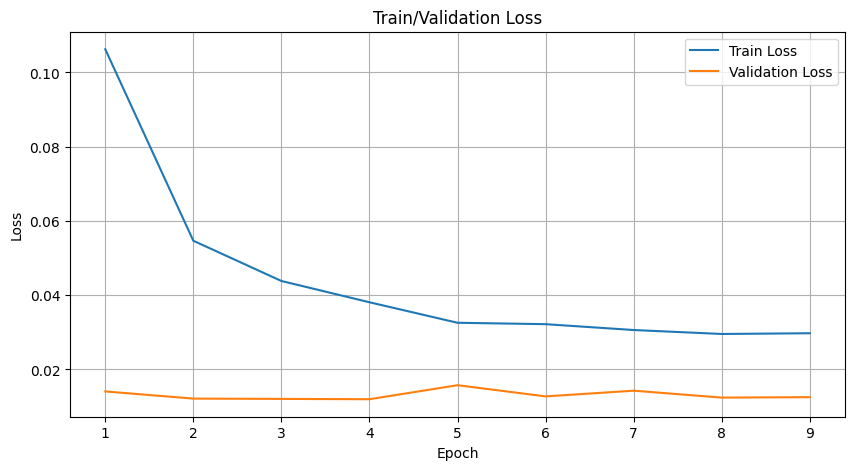

In [6]:
plot_training_history(history)

In [29]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_datasampler/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [7]:
output= test_patient_outcome_model(model, test_loader, device)

241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118

241 --- torch.Size([2, 10])
99 --- torch.Size([2, 10])
5 torch.Size([2, 10])
EDGE_INDEX: torch.Size([2, 10])		LOOP_INDEX: torch.Size([2, 5])
241 --- torch.Size([2, 10])
99 --- torch.Size([2, 10])
5 torch.Size([2, 10])
EDGE_INDEX: torch.Size([2, 10])		LOOP_INDEX: torch.Size([2, 5])


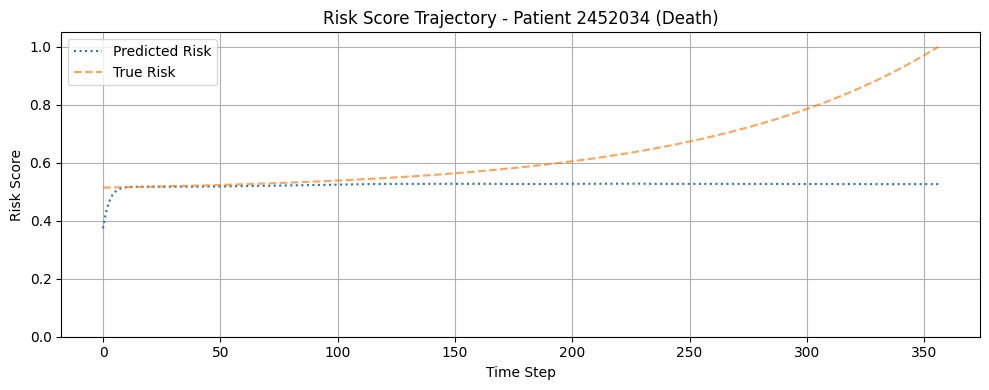

In [8]:
plot_patient_risk_score(model, test_loader, patient_index=195, device=device)

241 --- torch.Size([2, 12])
99 --- torch.Size([2, 12])
4 torch.Size([2, 12])
EDGE_INDEX: torch.Size([2, 12])		LOOP_INDEX: torch.Size([2, 4])
241 --- torch.Size([2, 12])
99 --- torch.Size([2, 12])
4 torch.Size([2, 12])
EDGE_INDEX: torch.Size([2, 12])		LOOP_INDEX: torch.Size([2, 4])


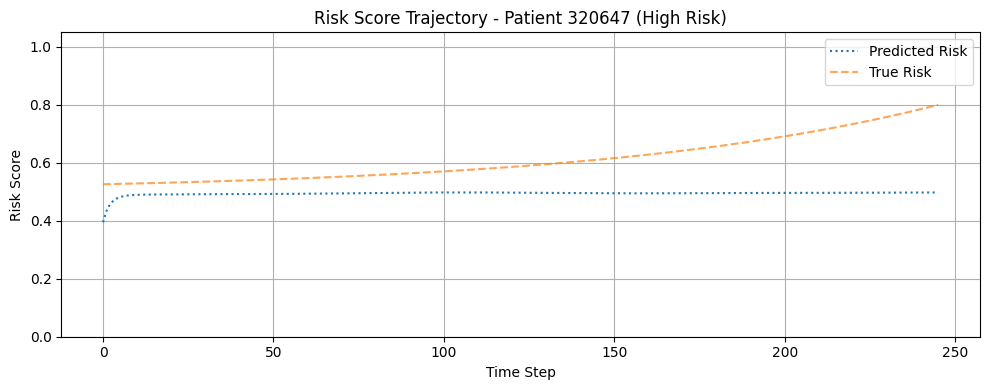

In [9]:
plot_patient_risk_score(model, test_loader, patient_index=398, device=device)

241 --- torch.Size([2, 12])
99 --- torch.Size([2, 12])
6 torch.Size([2, 12])
EDGE_INDEX: torch.Size([2, 12])		LOOP_INDEX: torch.Size([2, 6])
241 --- torch.Size([2, 12])
99 --- torch.Size([2, 12])
6 torch.Size([2, 12])
EDGE_INDEX: torch.Size([2, 12])		LOOP_INDEX: torch.Size([2, 6])


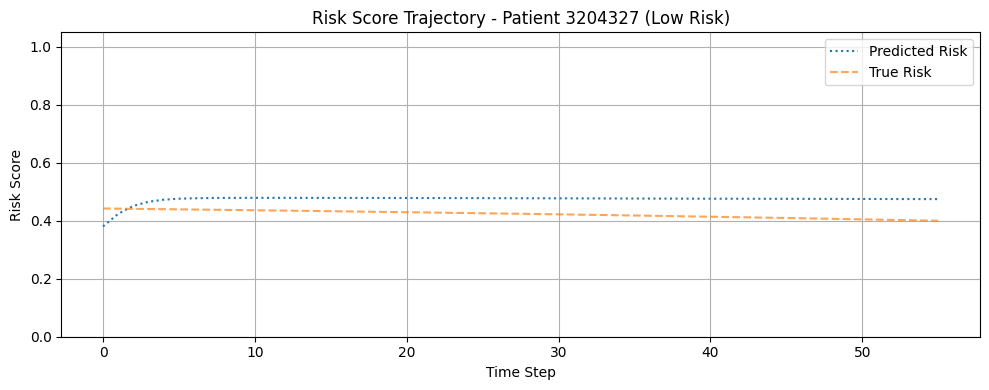

In [10]:
plot_patient_risk_score(model, test_loader, patient_index=397, device=device)

241 --- torch.Size([2, 6])
99 --- torch.Size([2, 6])
4 torch.Size([2, 6])
EDGE_INDEX: torch.Size([2, 6])		LOOP_INDEX: torch.Size([2, 4])
241 --- torch.Size([2, 6])
99 --- torch.Size([2, 6])
4 torch.Size([2, 6])
EDGE_INDEX: torch.Size([2, 6])		LOOP_INDEX: torch.Size([2, 4])


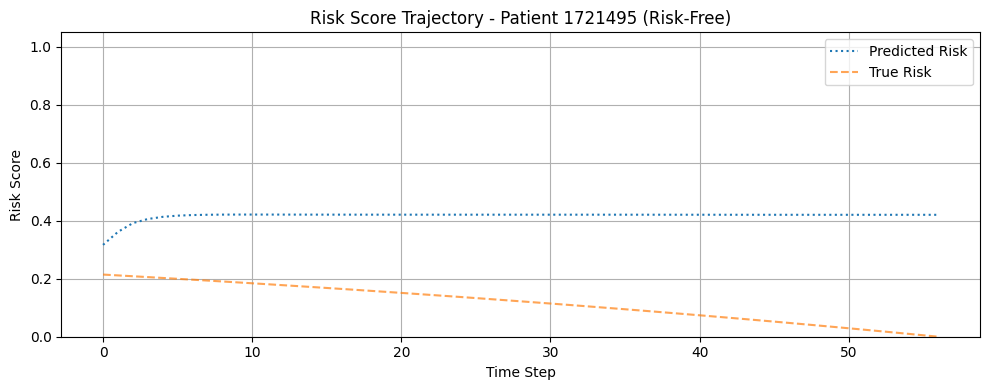

In [11]:
plot_patient_risk_score(model, test_loader, patient_index=51, device=device)

In [12]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [13]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_datasampler_higher_gbk/best_joint.pth'
model2 = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
model2.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118

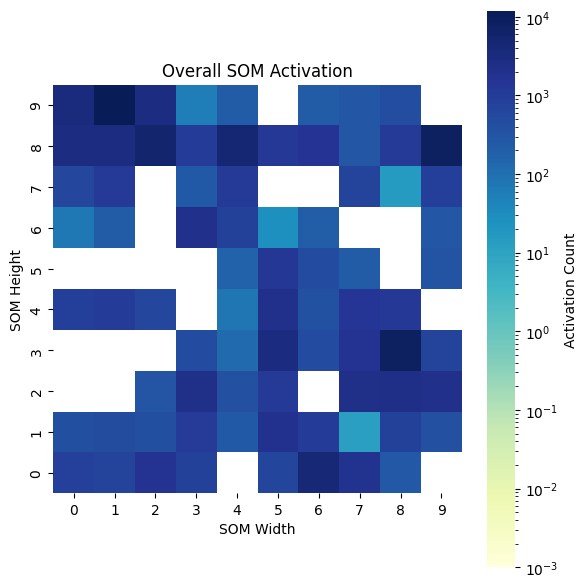

In [14]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model2, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

In [15]:
def plot_som_avg_risk(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        vmin=0.0, vmax=1.0,
        cmap=cmap,
        annot=True, fmt=".2f",
        # linewidths=.5, linecolor="gray"
    )
    plt.title("SOM Node Avg Risk")
    plt.xlabel("SOM Width"); plt.ylabel("SOM Height")
    plt.gca().invert_yaxis() #
    plt.tight_layout()
    plt.show()


--- Computing SOM Average Risk Heatmap ---


Calculating heatmap:   0%|          | 0/4 [00:00<?, ?it/s]

241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])


Calculating heatmap:  25%|██▌       | 1/4 [00:04<00:13,  4.48s/it]

241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])


Calculating heatmap:  50%|█████     | 2/4 [00:09<00:09,  4.55s/it]

241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])


Calculating heatmap:  75%|███████▌  | 3/4 [00:13<00:04,  4.42s/it]

241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118])
EDGE_INDEX: torch.Size([2, 1118])		LOOP_INDEX: torch.Size([2, 416])
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118])
EDGE_INDEX: torch.Size([2, 1118])		LOOP_INDEX: torch.Size([2, 416])


Calculating heatmap: 100%|██████████| 4/4 [00:15<00:00,  3.94s/it]


--> Heatmap computation complete.


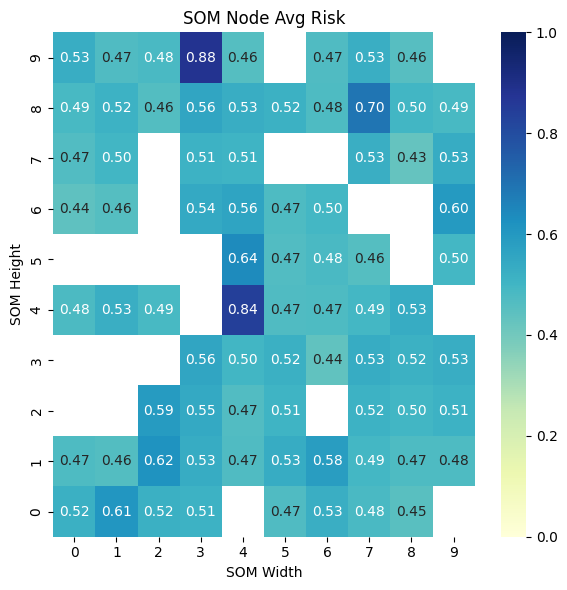

In [16]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

In [17]:
print_statistics_of_dataloader(test_loader)

test_loader 中 cat=0 的样本索引： [327, 194, 122, 161, 303, 123, 127, 51, 117, 109, 241, 279, 48, 61, 53, 302, 114, 18, 131, 77, 75, 88, 46, 43, 418, 71, 330]
cat=0 的患者 ID: [3118263, 2441148, 1848702, 2235716, 3064491, 1849239, 1854497, 1721495, 1842081, 1822777, 2642496, 2851573, 1718669, 1730209, 1722941, 3063135, 1833798, 1334230, 1857925, 1764355, 1762378, 1788553, 1364166, 1358338, 3232813, 1754475, 3123772]
cat=0 的样本长度: [475, 246, 152, 145, 80, 79, 58, 57, 55, 49, 49, 49, 48, 48, 47, 47, 44, 44, 44, 43, 42, 41, 39, 36, 36, 35, 32]
test_loader 中 cat=1 的样本索引： [15, 235, 28, 267, 286, 326, 98, 188, 380, 334, 52, 331, 240, 352, 273, 423, 56, 70, 42, 391, 179, 377, 217, 103, 140, 269, 356, 76, 40, 236, 408, 97, 130, 416, 315, 99, 208, 0, 372, 407, 319, 102, 126, 378, 347, 409, 219, 313, 368, 92, 72, 417, 111, 403, 447, 289, 31, 178, 81, 390, 229, 67, 115, 184, 3, 263, 419, 277, 439, 294, 274, 437, 268, 54, 264, 354, 259, 388, 191, 124, 311, 340, 233, 255, 105, 299, 246, 73, 5, 26, 35, 116, 1,

In [18]:
# --- 1. 计算热力图 ---
risk_heatmap = compute_som_avg_risk(model, test_loader, device, som_dim=(10, 10))

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap:   0%|          | 0/4 [00:00<?, ?it/s]

241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])


Calculating heatmap:  25%|██▌       | 1/4 [00:04<00:12,  4.29s/it]

241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])


Calculating heatmap:  50%|█████     | 2/4 [00:08<00:08,  4.09s/it]

241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])


Calculating heatmap:  75%|███████▌  | 3/4 [00:12<00:04,  4.16s/it]

241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118])
EDGE_INDEX: torch.Size([2, 1118])		LOOP_INDEX: torch.Size([2, 416])
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118])
EDGE_INDEX: torch.Size([2, 1118])		LOOP_INDEX: torch.Size([2, 416])


Calculating heatmap: 100%|██████████| 4/4 [00:14<00:00,  3.72s/it]

--> Heatmap computation complete.


--- Searching for specified patient IDs: ['3118263'] ---


Searching for patients:  50%|█████     | 2/4 [00:06<00:06,  3.28s/it]

  -> Found 1 target(s) in current batch. Running forward pass...
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])


Searching for patients:  50%|█████     | 2/4 [00:10<00:10,  5.37s/it]

    -> Computed trajectory for Patient ID: 3118263 (Category: 0)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [474]


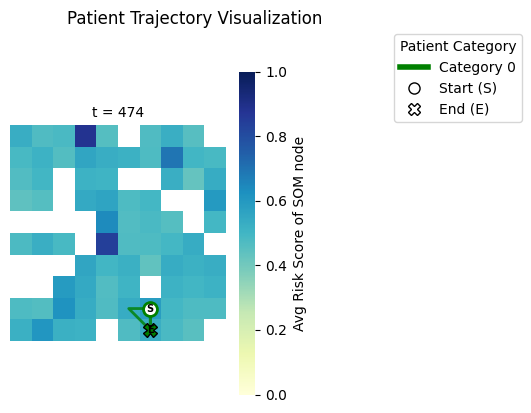

In [19]:

#cat=0
patient_ids = ['3118263'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['1334991'] ---


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Found 1 target(s) in current batch. Running forward pass...
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])


Searching for patients:   0%|          | 0/4 [00:04<?, ?it/s]

    -> Computed trajectory for Patient ID: 1334991 (Category: 1)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [271]


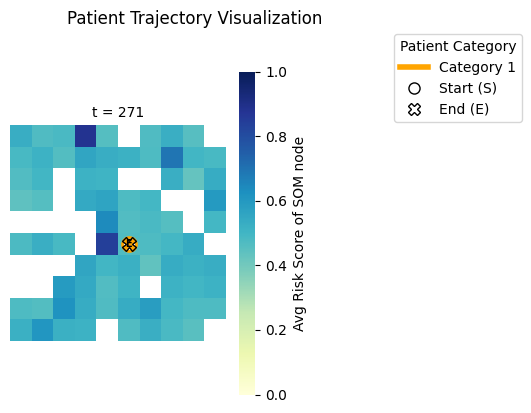

In [20]:
#cat=1
# 1753227, 1357048
# --- 2. 计算目标病人的轨迹 ---
patient_ids =  ['1334991']  
# 1796288, 1775230, 2621071, 2582752, 2434875
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

#开始，1/4处，1/2处，3/4处，和结束前一个点
# max_len // 2,  
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['3218348'] ---


Searching for patients:  75%|███████▌  | 3/4 [00:10<00:03,  3.51s/it]

  -> Found 1 target(s) in current batch. Running forward pass...
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118])
EDGE_INDEX: torch.Size([2, 1118])		LOOP_INDEX: torch.Size([2, 416])
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118])
EDGE_INDEX: torch.Size([2, 1118])		LOOP_INDEX: torch.Size([2, 416])


Searching for patients:  75%|███████▌  | 3/4 [00:12<00:04,  4.27s/it]

    -> Computed trajectory for Patient ID: 3218348 (Category: 2)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [524]


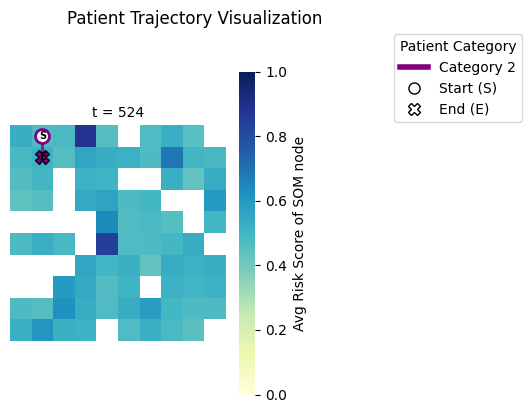

In [21]:
#cat=2
patient_ids = ['3218348'] 
#  3218348, 2855985, 2160015, 2602560,
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2524513'] ---


Searching for patients:  25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

  -> Found 1 target(s) in current batch. Running forward pass...
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])


Searching for patients:  25%|██▌       | 1/4 [00:07<00:21,  7.28s/it]

    -> Computed trajectory for Patient ID: 2524513 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [264]


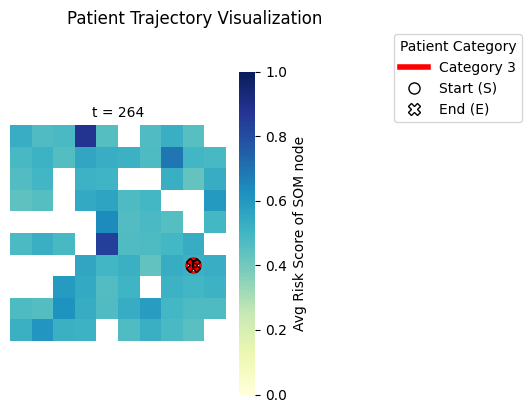

In [22]:
#cat=3
patient_ids = ['2524513'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

In [114]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_datasampler_v2"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            gamma=1, beta=1, kappa=1,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Ep30: Calculating global target P...


[Joint] Ep40: Calculating global target P...


[Joint] Ep50: Calculating global target P...


[Joint] Ep60: Calculating global target P...


[Joint] Early stopping at epoch 65 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


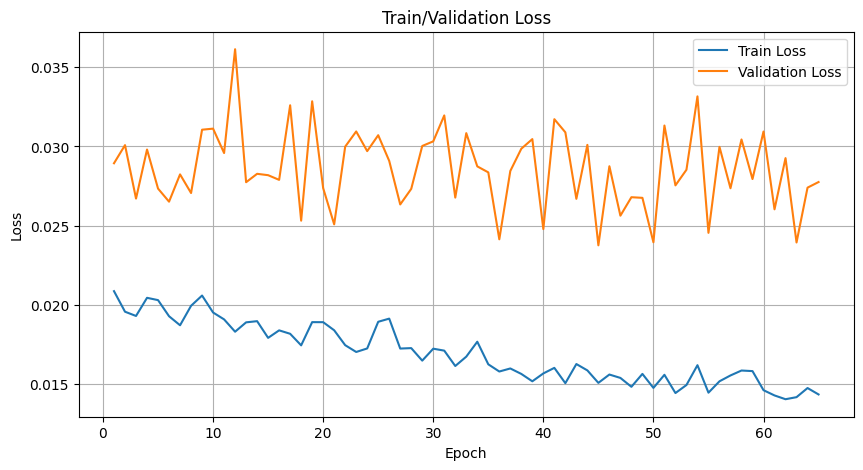

In [115]:
plot_training_history(history)

In [116]:
output= test_patient_outcome_model(model, test_loader, device)

Test Risk    → RMSE: 0.1731, R²: 0.1459
Test Risk κ→ Cohen's κ: 0.0965


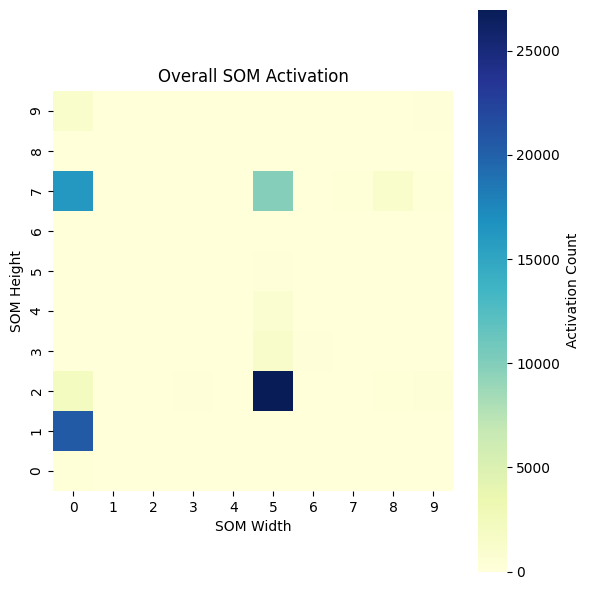

In [117]:
som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)


--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


--> Heatmap computation complete.


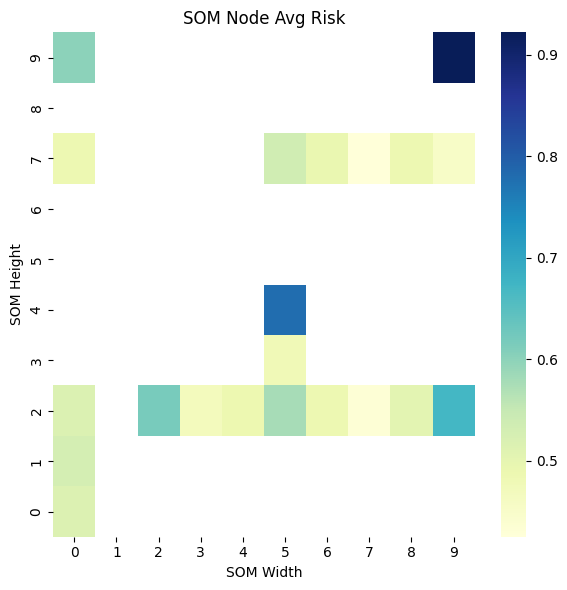

In [118]:
som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

In [4]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_datasampler_higher_gbk"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 27 due to no improvement for 20 epochs.
[Joint] Loading best model weights.
